# Revolutionizing Model Development in Digital Pathology: From Weeks to Minutes

The journey of developing AI systems within the realm of digital pathology presents extreme challenges, primarily due to the complexity of managing and processing vast datasets. Traditionally, transforming this data into a usable format for model development was a cumbersome and time-intensive task. With the rise of foundation embedders (models trained on huge corpora of images), the initial steps of model development have been dramatically streamlined.

In this post, we explore how Proscia's Concentriq® Embeddings platform transforms the way data scientists and researchers approach AI-driven projects. In this post, we demonstrate the power and simplicity of model development. In this case, we are building a tumor segmentation model. Remarkably, this process requires nothing more than a standard laptop, eliminating the need for costly GPU infrastructure and the logistical complexities associated with handling terabytes of training data. Join us as we showcase how Concentriq® Embeddings accelerates the path from concept to execution, making sophisticated model development accessible and expedient.


# CAMELYON17 tumor segmentation using Concentriq® Embeddings

The [Camelyon17 dataset](https://camelyon17.grand-challenge.org/) consists of whole slide images (WSIs) in TIFF format collected from 5 medical centers in the Netherlands. Lesion-level annotations are provided for 100 slides, creating an ideal example to demonstrate how to use Concentriq® Embeddings to quickly build a model for tumor segmentation. We’ll accomplish this by performing classification on high-resolution tile embeddings. 

After loading the dataset into Concentriq® for Research, embedding is initiated via a simple API job request. When the job is done, we download the embeddings, which are stored as safetensors, streamlining operations with a standard format. The embeddings are much smaller than the original WSIs at approximately a factor of 256 compression, enabling straightforward manipulation and analysis even on standard laptops.

In this notebook, we will illustrate how to:
- Generate embeddings at 1 micron per pixel (mpp, approx. 10X) using the [DINOv2 model](https://huggingface.co/docs/transformers/main/en/model_doc/dinov2)
- Load embeddings and labels
- Define and train a simple multi-layer perceptron (MLP) pytorch model
- Evaluate patch-level performance
- Visualize predictions with heatmaps

We take this simple approach (no deep learning involved) to illustrate of the power of features derived from even a foundation model trained only on natural images and to show that Concentriq® Embeddings can be used by anyone with a little programming know-how. (Note, that Concentriq® Embeddings does support several pathology-specific models)


In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import yaml

from utils.client import ClientWrapper as Client
from utils import utils

Image.MAX_IMAGE_PIXELS = None

In [2]:
with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

# To use CPU instead of GPU, set `device` parameter to `"cpu"`
ce_api_client = Client(**creds, device='cpu')
ce_api_client

# Let's get some embeddings

Now let's embed the Camelyon17 repo (stored on Concentriq® for Research with repo ID 2784) at 1 mpp resolution using the default (DINOv2) model, and print out the ticket ID. 

In [3]:
repository_ids = [2784]
ticket_id = ce_api_client.embed_repos(ids=repository_ids, model="facebook/dinov2-base", mpp=1)

In [4]:
# Optionally load embeddings from a previously created ticket
# ticket_id = '70f0ac5f-91cf-4d34-81a1-6252546638d1' # repo 2784 at 1mpp
embeddings = ce_api_client.get_embeddings(ticket_id)

In [5]:
len(embeddings['images'])

100

Congratulations, you're now a foundation model wizard. You have your embeddings in just a few lines of code!

# Let's match embeddings to metadata
We're going to want to associate embeddings with the corresponding image names. Concentriq® Embeddings already links images to an ID, so we just want to match those Concentriq® `image_id`s with `image_names`. Other metadata can be linked this way too. Here we're just pulling this data using the `ConcentriqLSClient` using the `get_images_in_a_repo` method. The `ConcentriqLSClient` uses the same authentication credentials as the embeddings API.

In [6]:
from utils.client import ConcentriqLSClient

cls = ConcentriqLSClient(**creds)
concentriq_metadata = cls.get_images_in_a_repo(repository_ids[0])

columns = ["id", "mppx", "mppy", "imgWidth", "imgHeight", "objectivePower", "slideName"]
concentriq_metadata = pd.DataFrame(concentriq_metadata["images"])[columns]
concentriq_metadata.rename(columns={"id": "image_id"}, inplace=True)

concentriq_metadata["image_base_name"] = concentriq_metadata["slideName"].apply(lambda x: x.split(".")[0])
print(concentriq_metadata.shape)
concentriq_metadata.head()

(100, 8)


image_id      mppx      mppy  imgWidth  imgHeight  objectivePower  \
0      8410  0.243094  0.243094     96651     197226              40   
1      8411  0.243094  0.243094     96651     197226              40   
2      8412  0.243094  0.243094     94968     210579              40   
3      8413  0.226316  0.226321    131072     103936              40   
4      8414  0.243094  0.243094     94968     210579              40   

                slideName     image_base_name  
0  patient_016_node_1.tif  patient_016_node_1  
1  patient_073_node_1.tif  patient_073_node_1  
2  patient_000_node_4.tif  patient_000_node_4  
3  patient_057_node_4.tif  patient_057_node_4  
4  patient_020_node_4.tif  patient_020_node_4

The retrieved embedding file includes metadata about the embeddings job we submitted and each WSI processed. The embeddings themselves are loaded as a dictionary of tensors with keys in "Y_X" format indicating the grid index of the embedded patch.

Here we print the information corresponding to each WSI. This includes the parameters supplied along with implicit attributes of the data, like the foundation model’s native patch size, as well as all of the other spatial information associated with each WSI’s tile embeddings.

In [7]:
for key, value in embeddings['images'][0].items():
    if key not in ['embedding', 'thumbnail', 'embeddings_url']:
        print(f"{key}: {value}")

image_id: 8461
repository_id: 2784
status: finished
model: facebook/dinov2-base
patch_size: 224
grid_rows: 215
grid_cols: 105
pad_height: 216
pad_width: 25
mpp: 1.0
local_embedding_path: ./data/70f0ac5f-91cf-4d34-81a1-6252546638d1_8461.safetensors


# ... And add tile-level labels
Now we want to match each tile embedding with its corresponding label. To do this, we can create a dataframe with one row per embedded tile along with the grid location and the mask value for that tile.


In [8]:
datapath = "data/camelyon17/masks/"
reslist = []
for i, row in concentriq_metadata.iterrows():
    image_id = row["image_id"]
    image_base_name = row["image_base_name"]
    emb = [e for e in embeddings['images'] if e["image_id"] == image_id][0]
    tile_res_mask_path = os.path.join(datapath, f"{image_base_name}_mask.png")
    tile_res_mask = imageio.v2.imread(tile_res_mask_path)    
    # For each image, create one row per tile in the mask
    for i in range(emb["grid_rows"]):
        for j in range(emb["grid_cols"]):
            mask_value = tile_res_mask[i, j]
            res = {"image_id": image_id,
                   "image_base_name": image_base_name,
                   "label": mask_value,
                   "row": i,
                   "col": j,
                   "embedding": emb["embedding"][f"{i}_{j}"]}
            reslist.append(res)
dataset_df = pd.DataFrame(reslist)
dataset_df.shape

(1967019, 6)

In [9]:
dataset_df.head()

image_id     image_base_name  label  row  col  \
0      8410  patient_016_node_1      0    0    0   
1      8410  patient_016_node_1      0    0    1   
2      8410  patient_016_node_1      0    0    2   
3      8410  patient_016_node_1      0    0    3   
4      8410  patient_016_node_1      0    0    4   

                                           embedding  
0  [tensor(1.1116), tensor(-2.8563), tensor(3.437...  
1  [tensor(1.1116), tensor(-2.8563), tensor(3.437...  
2  [tensor(1.1116), tensor(-2.8563), tensor(3.437...  
3  [tensor(1.1116), tensor(-2.8563), tensor(3.437...  
4  [tensor(1.1116), tensor(-2.8563), tensor(3.437...

In [10]:
dataset_df['label'].value_counts()

label
0    1550701
1     410897
2       5421
Name: count, dtype: int64

Restrict the dataset to tiles containing tissue.

In [11]:
dataset_df = dataset_df[dataset_df['label'] > 0]
dataset_df.index = range(len(dataset_df))
dataset_df.shape

(416318, 6)

# Create training and test splits
Split the dataset into 80% train and 20% test while stratifying over images.

In [12]:
np.random.seed(12356)
test_ids = np.random.choice(dataset_df['image_id'].unique(), 20, replace=False)
train = dataset_df[~dataset_df['image_id'].isin(test_ids)].copy()
test = dataset_df[dataset_df['image_id'].isin(test_ids)].copy()
del dataset_df
train['image_id'].nunique(), test['image_id'].nunique()

(80, 20)

# Train a model

Next, we’ll build a simple classifier over tile embeddings to produce a low-resolution segmentation map distinguishing tumor from normal tissue. This extremely simplified feedforward, multilayer perceptron model and training procedure is adapted from this [pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [13]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class CamelyonDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.df.index = range(self.df.shape[0])

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        embedding = row['embedding']
        label = row['label']
        return embedding, torch.Tensor([label-1]).long() # .to('cuda')
    
train_dataset = CamelyonDataset(train)
test_dataset = CamelyonDataset(test)

In [14]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x


net = Net() #.to('cuda')

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  1000] loss: 0.034
[1,  2000] loss: 0.020
[1,  3000] loss: 0.017
[1,  4000] loss: 0.015
[1,  5000] loss: 0.013
[2,  1000] loss: 0.012
[2,  2000] loss: 0.011
[2,  3000] loss: 0.011
[2,  4000] loss: 0.011
[2,  5000] loss: 0.010
[3,  1000] loss: 0.010
[3,  2000] loss: 0.010
[3,  3000] loss: 0.009
[3,  4000] loss: 0.009
[3,  5000] loss: 0.009
[4,  1000] loss: 0.009
[4,  2000] loss: 0.008
[4,  3000] loss: 0.008
[4,  4000] loss: 0.008
[4,  5000] loss: 0.009
[5,  1000] loss: 0.008
[5,  2000] loss: 0.008
[5,  3000] loss: 0.008
[5,  4000] loss: 0.008
[5,  5000] loss: 0.008
Finished Training


# Evaluate
Great, now we’ve built a Camelyon17 segmentation model in minutes. Let’s assess the performance of the model on the test set. First, we’ll just look at tilewise accuracy.

In [17]:
correct = 0
total = 0
preds = []
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        preds.append(outputs.data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.squeeze().size(0)
        correct += (predicted == labels.squeeze()).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 99 %


Okay, that looks good, but let’s see what other metrics look like.

In [18]:
pred = torch.cat(preds)
tumor_pred = torch.softmax(pred, dim=1)[:, 1]
test['pred'] = tumor_pred.cpu().numpy()
test['pred_label'] = torch.argmax(pred, dim=1).cpu().numpy()

In [19]:
utils.calculate_boolean_metrics(gt = test['label']-1, pred = test['pred_label'])

{'cm': array([[86121,    63],
        [  132,   219]]),
 'tp': 219,
 'fp': 63,
 'tn': 86121,
 'fn': 132,
 'sen': 0.6239316061557948,
 'spe': 0.9992690057320072,
 'ppv': 0.7765957171419959,
 'npv': 0.9984696183322934,
 'acc': 1.0,
 'f1': 0.69}

In [20]:
iou = utils.calculate_iou(gt = test['label']-1, pred = test['pred_label'])
dice = utils.calculate_dice(gt = test['label']-1, pred = test['pred_label'])
iou, dice

(0.5289855072475145, 0.691943127962572)

So overall the model has very high specificity and sensitivity is lower, but this seems very respectable for a tiny model that took us under an hour to put together on a laptop, including time spent fetching the data from Concentriq®.

# Visualize
Let’s see what our segmentations look like. 

For this we'll grab thumbnail images at 7 microns per pixel from the thumbnails endpoint.


In [21]:
thumbnail_ticket_id = ce_api_client.thumbnail_repos(ids=repository_ids)

In [23]:
thumbnails = ce_api_client.get_thumbnails(thumbnail_ticket_id, load_thumbnails=True)

status='completed' progress=1.0 finished=100 failed=0 queued=0 processing=0


In [24]:
# link the thumbnails to the embeddings
for emb in embeddings['images']:
    thumbnail_dict = [thumb for thumb in thumbnails['thumbnails'] if thumb['image_id'] == emb['image_id']][0]
    emb.update(thumbnail_dict)

We can plot the ground truth masks next to model predictions and visualize tumor region predictions as heat maps overlaid on image thumbnails.

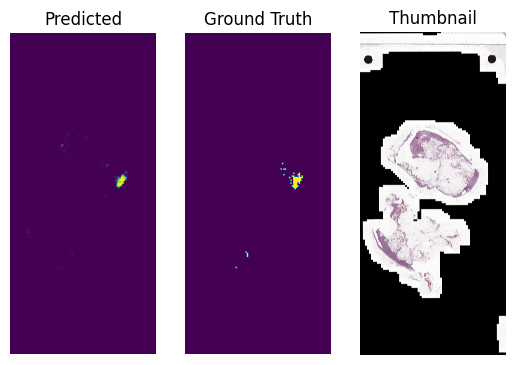

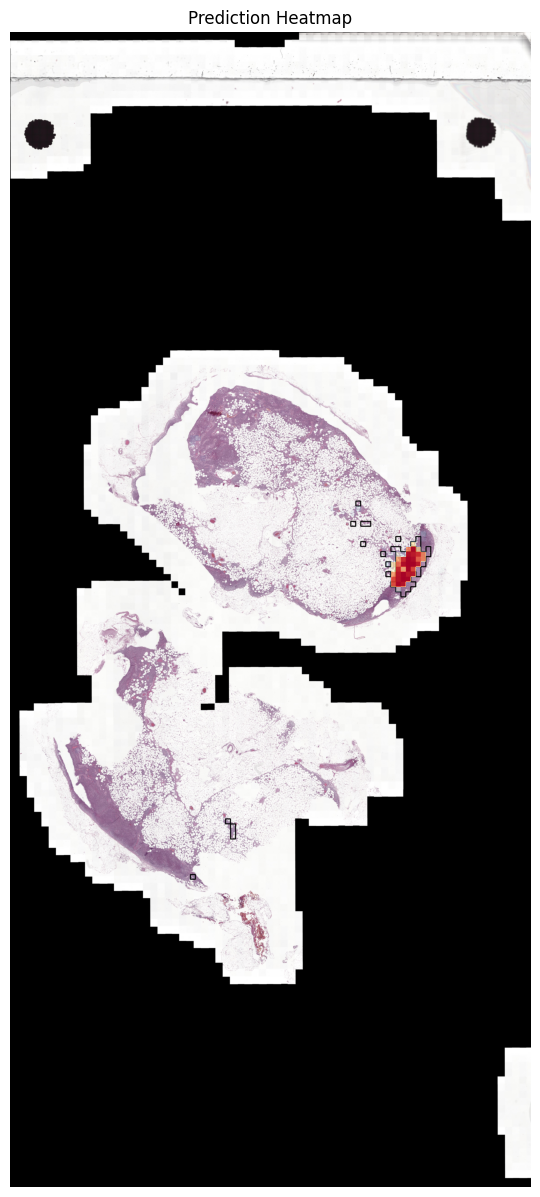

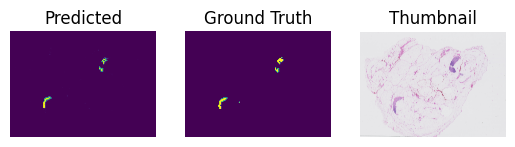

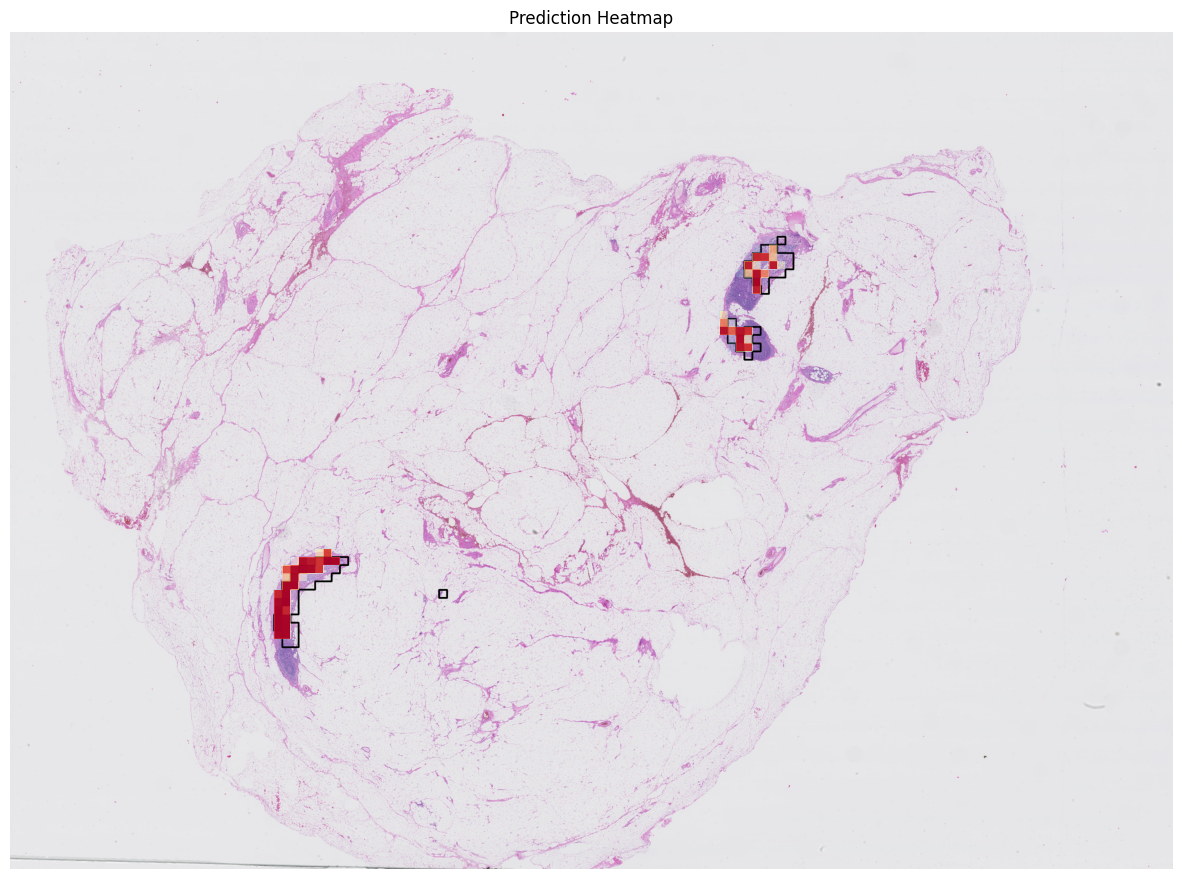

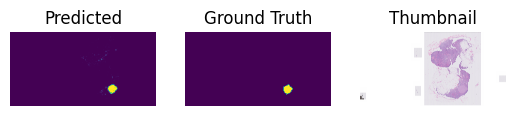

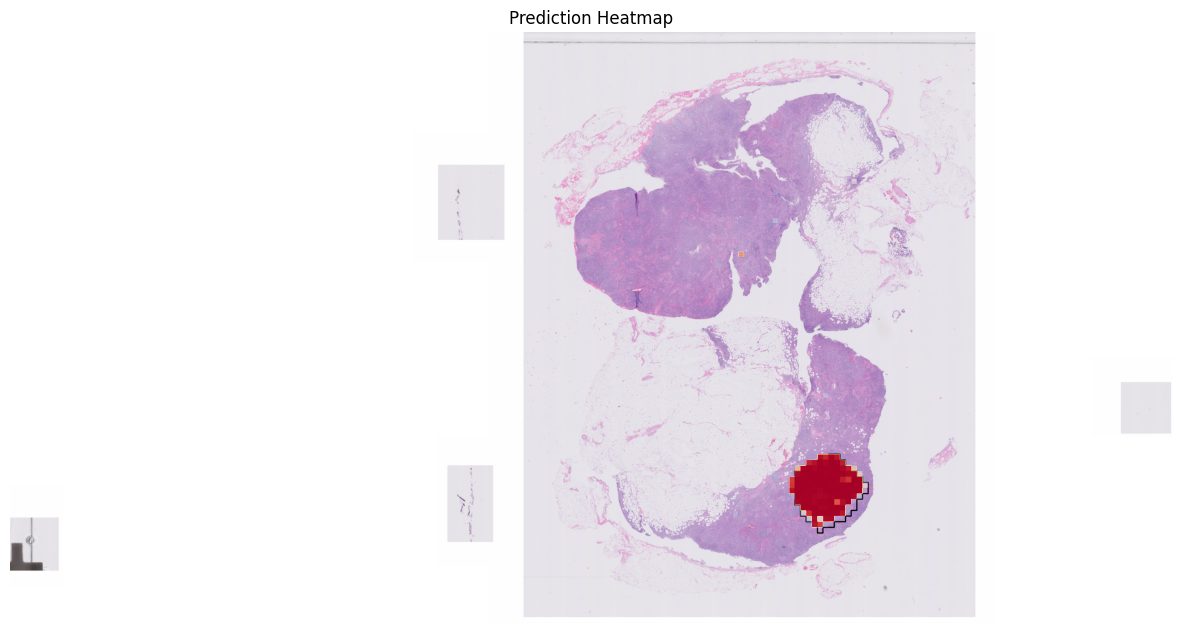

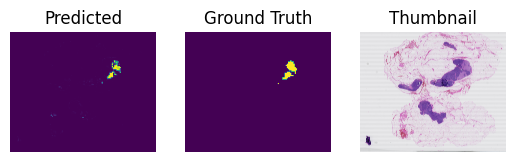

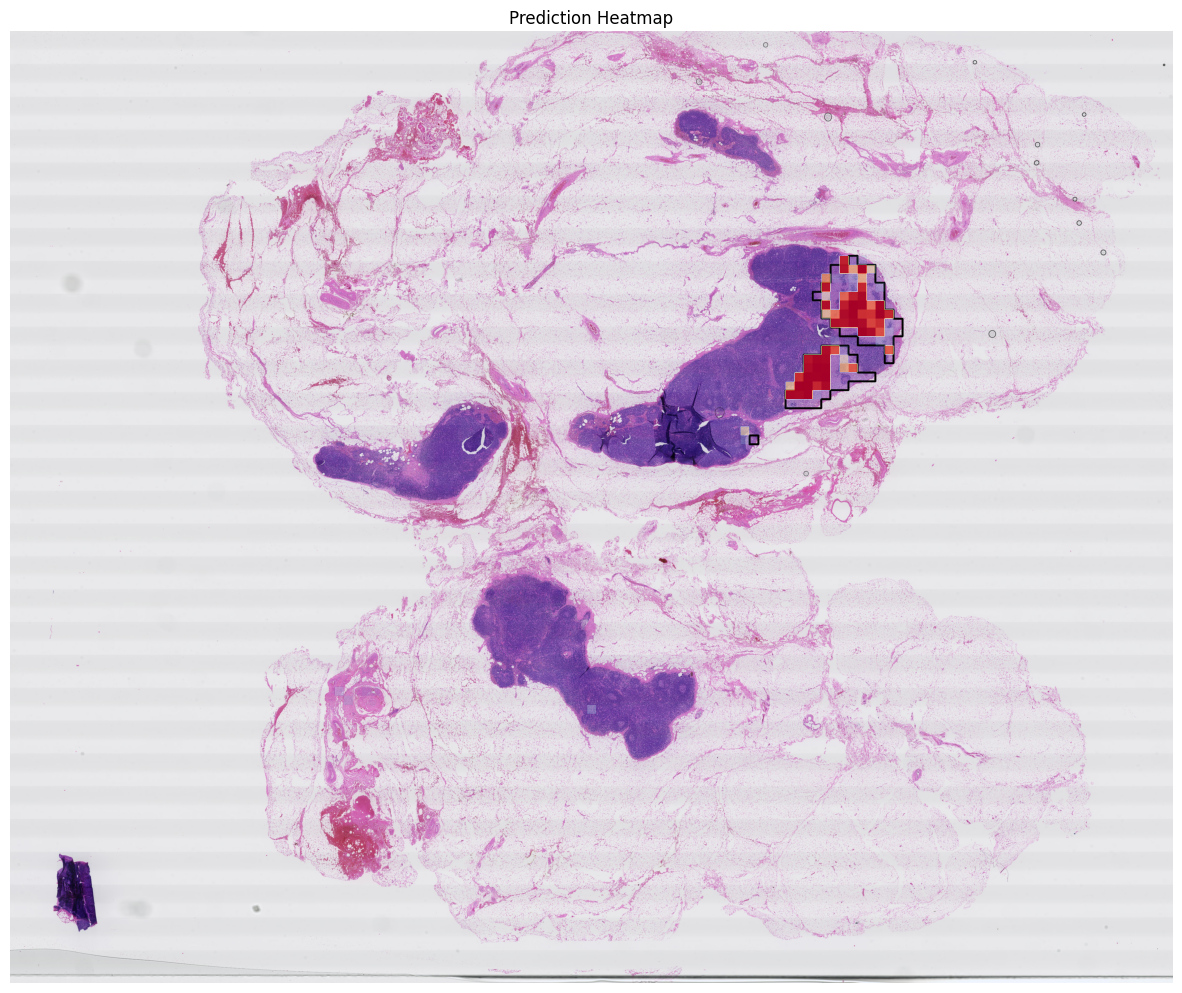

In [25]:
ious = []
dices = []

gb = test.groupby('image_id')
for image_id, image_df in gb:
    if (image_df['label'] == 2).sum() < 10:
        # skip images with no or very little tumor
        continue
    
    emb = [e for e in embeddings['images'] if e["image_id"] == image_id][0]
    mat = np.zeros((emb['grid_rows'], emb['grid_cols']))
    for i, row in image_df.iterrows():
        mat[row['row'], row['col']] = row['pred']
    image_base_name = image_df['image_base_name'].values[0]
    fig, axx = plt.subplots(1,3)
    axx[0].imshow(mat)
    axx[0].set_title("Predicted")
    axx[0].axis('off')
    
    gt_mask = imageio.v2.imread(os.path.join(datapath, f"{image_base_name}_mask.png"))==2
    axx[1].imshow(gt_mask)
    axx[1].set_title("Ground Truth")
    axx[1].axis('off')
    axx[2].imshow(emb['thumbnail'])
    axx[2].set_title("Thumbnail")
    axx[2].axis('off')
    plt.show()
    pred_thumb = cv2.resize(mat, (emb['thumbnail'].shape[1], emb['thumbnail'].shape[0]), 0, 0, interpolation=cv2.INTER_NEAREST)

    fig, ax = plt.subplots(1,1, figsize=(15,15))
    ## create contours from the mask
    gt_mask_thumb_res = cv2.resize(gt_mask.astype('uint8'), (emb['thumbnail'].shape[1], emb['thumbnail'].shape[0]), 0, 0, interpolation=cv2.INTER_NEAREST)
    contours, _ = cv2.findContours(gt_mask_thumb_res.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    thumbnail = emb['thumbnail'].copy()
    thumbnail = cv2.drawContours(thumbnail, contours, -1, (1, 1, 0), 6)
    
    ax.imshow(thumbnail)
    ax.imshow(-pred_thumb, alpha=pred_thumb/pred_thumb.max(), cmap='RdYlBu', vmax=0, vmin=-1)
    ax.set_title("Prediction Heatmap")
    ax.axis('off')
    
    plt.show()

These visualizations seem to tell the same story as our metrics - imperfect, but fairly respectable performance for a small model and low effort. It’s that simple to make use of foundation models for segmentation with Concentriq® Embeddings.

# Conclusion
Concentriq® Embeddings revolutionizes the development of histopathology algorithms, streamlining the journey from prototyping to production. By harnessing the power of foundation model embeddings, the platform significantly speeds up every aspect of model development. Whether it's clustering, segmentation, or classification, Concentriq® Embeddings provides a robust foundation for AI-driven innovations in histopathology, turning processes that once took weeks into tasks that can be accomplished in less than an hour.